# Project: Web Traffic Forecasting


In [1]:
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from edward.models import Normal, Laplace, Empirical
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (24, 12)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
from models import *
from utils import *
from pipeline import *
from cross_validation import cross_validation

## Data

In [2]:
# Parameters
FPATH = "./data/nfl_teams.csv"
SDATE = pd.datetime(2017, 7, 10)

def get_timeseries(path):
    df = pd.read_csv(path)
    timeseries = {}
    print("Loading timeseries:")
    for i, row in df.iterrows():
        ts = pd.DataFrame({"ds": row.index[1:], "views": row.values[1:]})
        ts["y"] = ts["views"].astype(float)
        timeseries[row.Page] = ts
        print(row.Page)
#         plt.plot(ts["ds"], np.log(ts["y"]))
#         plt.xtick(rotation=90)
#         plt.show()
    return timeseries

timeseries = get_timeseries(FPATH)

Loading timeseries:
Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents
Denver_Broncos_en.wikipedia.org_mobile-web_all-agents
Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents
New_England_Patriots_en.wikipedia.org_mobile-web_all-agents
Los_Angeles_Rams_en.wikipedia.org_mobile-web_all-agents
Arizona_Cardinals_en.wikipedia.org_mobile-web_all-agents
Green_Bay_Packers_en.wikipedia.org_mobile-web_all-agents
National_Football_League_en.wikipedia.org_desktop_all-agents
Pittsburgh_Steelers_en.wikipedia.org_mobile-web_all-agents
Carolina_Panthers_en.wikipedia.org_mobile-web_all-agents


History: 741, Future: 62


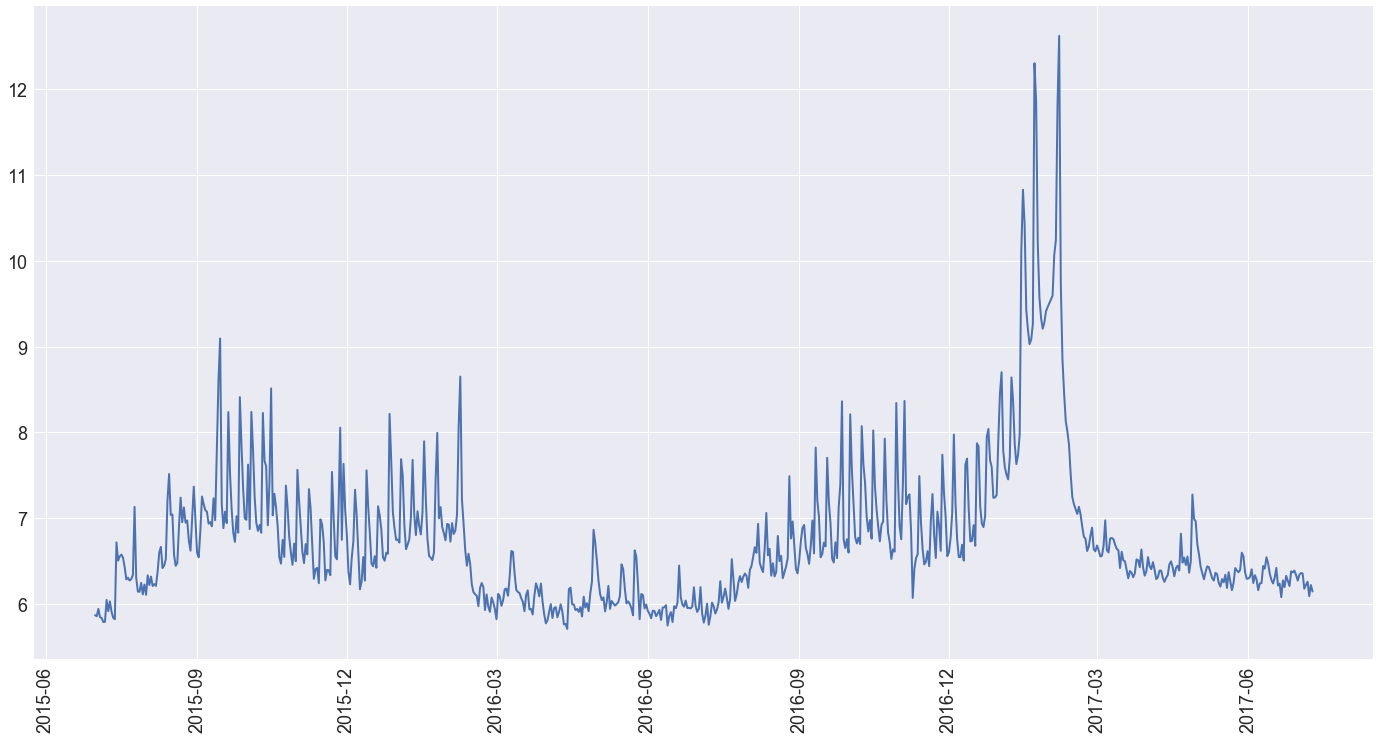

            ds   views         y
798 2017-09-06   926.0  6.830874
799 2017-09-07   938.0  6.843750
800 2017-09-08  1414.0  7.254178
801 2017-09-09  1102.0  7.004882
802 2017-09-10  2804.0  7.938802
History dataframe: 741
           ds  views         y         t  y_scaled
0 2015-07-01  353.0  5.866468  0.000000  0.464709
1 2015-07-02  349.0  5.855072  0.001351  0.463806
2 2015-07-03  380.0  5.940171  0.002703  0.470547
3 2015-07-04  345.0  5.843544  0.004054  0.462893
4 2015-07-05  342.0  5.834811  0.005405  0.462201


In [3]:
# Prepare dataframe
HAS_OUTLIER = False
df = timeseries["Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents"]
df["views"] = df["y"]
df["y"] = np.log(df["y"])
if(HAS_OUTLIER == True):
    df.loc[(df['ds'] > '2017-02-01') & (df['ds'] < '2017-03-01'), 'y'] = None
    df.loc[(df['ds'] > '2017-02-01') & (df['ds'] < '2017-03-01'), 'views'] = None
df  = setup_dataframe(df)

# Split data into train and test
history = df[df['ds'] <= SDATE].copy()
future = df[df['ds'] > SDATE].copy()
print("History: %d, Future: %d" % (history.shape[0], future.shape[0]))

plt.plot(history['ds'],history['y'])
plt.xticks(rotation=90)
plt.show()

# Add a scaled t (time index) and y (#views)
t_start = history['ds'].min()
t_scale = history['ds'].max() - t_start
if t_scale == 0:
    raise ValueError("Timeseries start == end")
y_scale = history['y'].max()
if y_scale == 0:
    y_scale = 1
history['t'] = (history['ds'] - t_start) / t_scale
history['y_scaled'] = history['y'] / y_scale

print(df.tail())
print("History dataframe: %d\n" % history.shape[0], history.head())

In [4]:
# Extract features
holiday_en_us = ['2015-01-01', '2015-01-19', '2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', 
                 '2016-01-01', '2016-01-18', '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-26', 
                 '2017-01-01', '2017-01-02', '2017-01-16', '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', 
                 '2017-12-25',
                 '2015-02-14', '2016-02-14', '2017-02-14']
holidays = pd.DataFrame({
  'holiday': 'US public holiday',
  'ds': pd.to_datetime(holiday_en_us),
  'lower_window': -1,
  'upper_window': 0,
  'prior_scale': 10.0
})
holidays = None

seasonal_features, prior_scales = make_seasonality_features(history, yearly=True, weekly=True, 
                                                            holidays=holidays)
print("Seasonal features:\n")
print(seasonal_features.columns)
    
K = seasonal_features.shape[1] # number of seasonal factors
changepoints_t = get_changepoints(history, n_changepoints=25)
S = len(changepoints_t) # number of change points
changepoint_prior_scale = 0.05

print("Seasonal_features: %d\n" % K)

if holidays is not None:
    print("Holidays:\n")
    holiday_ds = []
    for feature in seasonal_features:
        if feature.split("_delim_")[0] in set(holidays['holiday']):
            holiday_ds.extend(seasonal_features[seasonal_features[feature]==1.0].index)
    print(history.iloc[np.unique(holiday_ds)]["ds"])


print("Changepoints: %d" % S)
X_train = {
    't': history['t'].as_matrix(), # day
    'A': get_changepoint_matrix(history, changepoints_t), # split indicator
    'X': seasonal_features, # seasonal vectors
    'sigmas': prior_scales, # scale on seasonality prior
}

Y_train = history['y_scaled'].as_matrix()

Seasonal features:

Index(['yearly_delim_1', 'yearly_delim_2', 'yearly_delim_3', 'yearly_delim_4',
       'yearly_delim_5', 'yearly_delim_6', 'yearly_delim_7', 'yearly_delim_8',
       'yearly_delim_9', 'yearly_delim_10', 'yearly_delim_11',
       'yearly_delim_12', 'yearly_delim_13', 'yearly_delim_14',
       'yearly_delim_15', 'yearly_delim_16', 'yearly_delim_17',
       'yearly_delim_18', 'yearly_delim_19', 'yearly_delim_20',
       'weekly_delim_1', 'weekly_delim_2', 'weekly_delim_3', 'weekly_delim_4',
       'weekly_delim_5', 'weekly_delim_6'],
      dtype='object')
Seasonal_features: 26

Changepoints: 25


## Model

In [12]:
# Model
t = tf.placeholder(tf.float32, shape=None, name="t")        # time index
A = tf.placeholder(tf.float32, shape=(None, S), name="A")      # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(None, K), name="X")      # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")  # scale on seasonality prior
#tau = tf.placeholder(tf.float32, shape=(), name="tau")      # scale on changepoints prior
tau = Normal(loc=tf.ones(1) * 0.05, scale=1.*tf.ones(1))

k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))           # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))           # initial intercept
sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise

delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))      # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta, name="gamma")

beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))     # seasonal

trend_loc = (k + ed.dot(A, delta)) * t + (m + ed.dot(A, gamma))
seas_loc = ed.dot(X, beta)
y = Normal(loc = trend_loc + seas_loc, scale = sigma_obs)

## Inference

In [13]:
# Inference
ITR = 5000                       # Number of samples.

# Init k, m
def init_km(df):
    i0, i1 = df['ds'].idxmin(), df['ds'].idxmax()
    T = df['t'].iloc[i1] - df['t'].iloc[i0]
    k = (df['y_scaled'].iloc[i1] - df['y_scaled'].iloc[i0]) / T
    m = df['y_scaled'].iloc[i0] -  k * df['t'].iloc[i0]
    return (k, m)

kinit, minit = init_km(history)
print("Initial slope / intercept: %f, %f" % (kinit, minit))
qk = Empirical(params=tf.Variable(kinit * tf.ones([ITR, 1])))
qm = Empirical(params=tf.Variable(minit * tf.ones([ITR, 1])))
qsigma_obs = Empirical(params=tf.Variable(tf.ones([ITR, 1])))
qbeta = Empirical(params=tf.Variable(tf.zeros([ITR, K])))
qdelta = Empirical(params=tf.Variable(tf.zeros([ITR, S])))
qtau = Empirical(params=tf.Variable(0.05 * tf.ones([ITR, 1])))

inference = ed.HMC({k: qk, m: qm, sigma_obs: qsigma_obs, beta: qbeta, delta:qdelta,
                    tau: qtau}, 
                   data={y: Y_train, 
                         t: X_train['t'],
                         A: X_train['A'], 
                         X: X_train['X'].as_matrix(), 
                         sigmas: X_train['sigmas'], 
                         t_change: changepoints_t})
                        #tau: changepoint_prior_scale}))
                         
inference.run(step_size=5e-4)

Initial slope / intercept: 0.021999, 0.464709
5000/5000 [100%] ██████████████████████████████ Elapsed: 62s | Acceptance Rate: 0.956


## Prediction

In [14]:
# Add scaled t and y
future['t'] = (future['ds'] - t_start) / t_scale
future['y_scaled'] = future['y'] / y_scale
print("Future dataframe: %d\n" % future.shape[0], future.head())
print()

# Extract seasonality features
future_seasonal, future_prior_scales = make_seasonality_features(future, 
                                                                 yearly=True, weekly=True,
                                                                 holidays=holidays)
assert(future_seasonal.shape[1] == K)
assert(all(future_seasonal.columns == seasonal_features.columns))

X_test = {
    't': future['t'].as_matrix(), # day
    'A': get_changepoint_matrix(future, changepoints_t), # split indicator
    'X': future_seasonal, # seasonal vectors
    'sigmas': future_prior_scales, # scale on seasonality prior
}

Y_test = future['y_scaled'].as_matrix()

sess = ed.get_session()
posteriors = {k: qk, m: qm, sigma_obs: qsigma_obs, beta: qbeta, delta:qdelta, tau:qtau}

# Evaluate test data
y_post = ed.copy(y, posteriors)
       
test_data = {t: X_test['t'],
             A: X_test['A'], X: X_test['X'].as_matrix(), 
             sigmas: X_test['sigmas'], t_change: changepoints_t}
                        #tau: changepoint_prior_scale}))

# Evaluate test data
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error',  #mean_absolute_percentage_error
                  data={y_post: Y_test, t: X_test['t'],
                        A: X_test['A'], X: X_test['X'].as_matrix(), 
                        sigmas: X_test['sigmas'], t_change: changepoints_t}))
                        #tau: changepoint_prior_scale}))

Future dataframe: 62
             ds  views         y         t  y_scaled
741 2017-07-11  430.0  6.063785  1.001351  0.480339
742 2017-07-12  458.0  6.126869  1.002703  0.485336
743 2017-07-13  797.0  6.680855  1.004054  0.529220
744 2017-07-14  462.0  6.135565  1.005405  0.486025
745 2017-07-15  458.0  6.126869  1.006757  0.485336

Mean squared error on test data:
0.00114842


## Evaluation on test data

Evalaute test data
MAPE = 6.052849
SMAPE = 5.861708
MSE = 0.001569


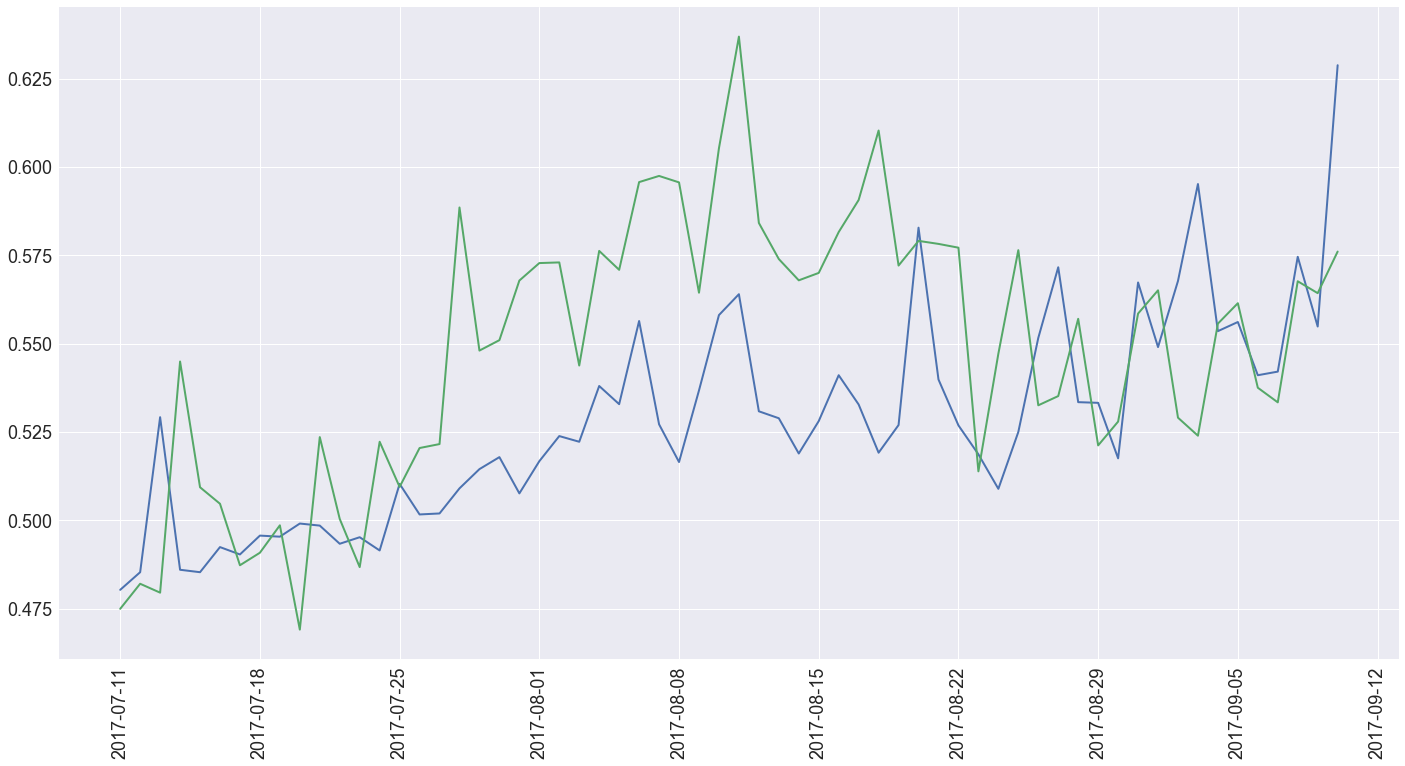

Test data before log
MAPE = 52.767336
SMAPE = 39.054938
MSE = 360886.801692


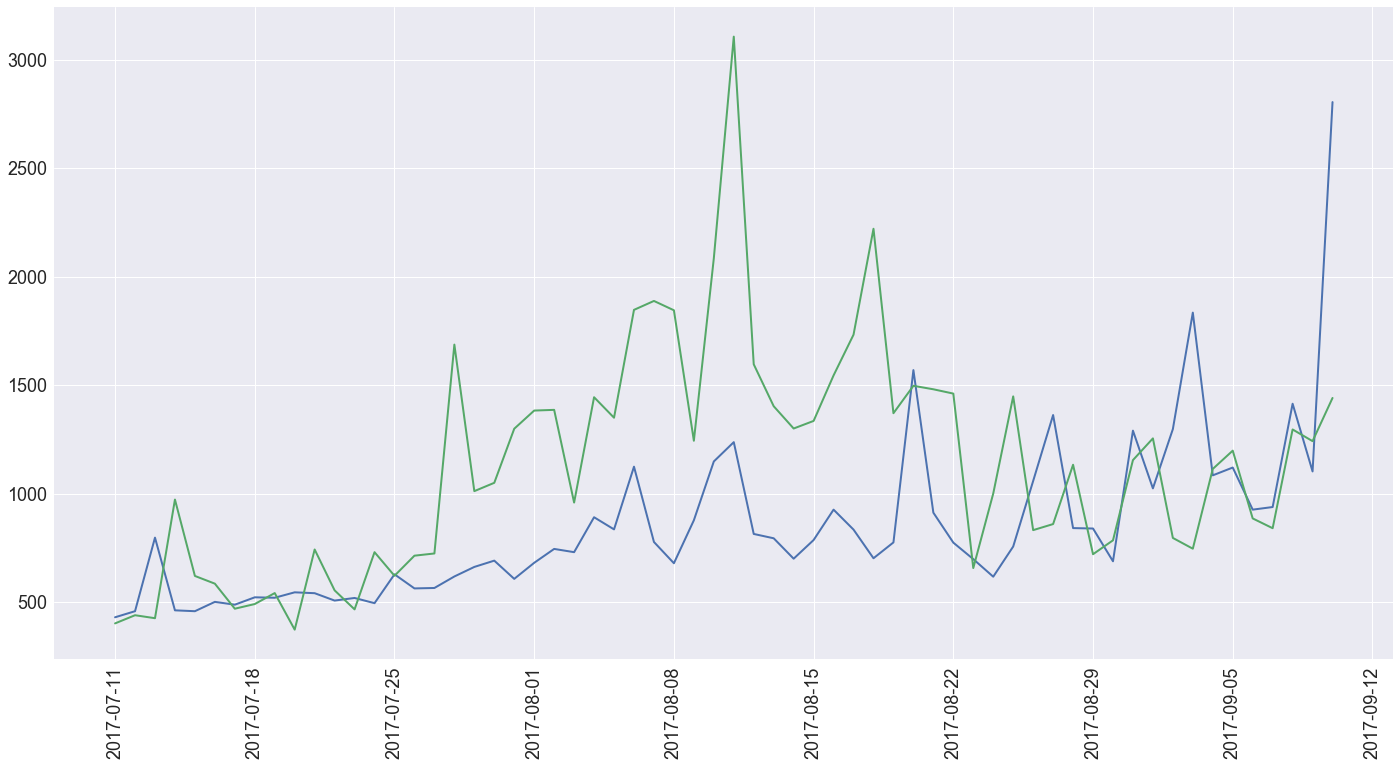

In [15]:
# Evaluate test data
# print("Mean squared error on test data:")
# print(ed.evaluate('mean_squared_error',  #mean_absolute_percentage_error
#                   data={y_post: Y_test, 
#                         t: X_test['t'],
#                         A: X_test['A'], 
#                         X: X_test['X'].as_matrix(), 
#                         sigmas: X_test['sigmas'], 
#                         t_change: changepoints_t,
#                         tau: changepoint_prior_scale}))
y_pred = np.array([sess.run([y_post], 
                  feed_dict=test_data) for _ in range(500)]).mean(axis=0)[0]

# Metrics 
def evaluate(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(np.abs((y_true - y_pred)) / (np.abs((y_true + y_pred)))) * 200
    mse = ((y_true - y_pred) ** 2).mean()
    print("MAPE = %f" % mape)
    print("SMAPE = %f" % smape)
    print("MSE = %f" % mse)
    
def plot_evaluate(ds, y_true, y_pred):
    plt.plot(ds, y_true)
    plt.plot(ds, y_pred)
    plt.xticks(rotation=90)
    
def plot_APE(ds, y_true, y_pred, pltname):
    ae = np.abs((y_true - y_pred)) * 100
    ptws = ae /(np.sum(ae))
    cum = np.cumsum(ptws)
    
    print(ae[:10])
    print(np.sum(ae))
    print(ptws[:10])
    
    ax1 = plt.subplot(311)
    plt.plot(ds,y_true)
    plt.plot(ds,y_pred)    
    plt.setp(ax1.get_xticklabels())
    
    ax2 = plt.subplot(312)
    plt.plot(ds,ptws)
    
    ax3 = plt.subplot(313, sharex=ax1)
    plt.plot(ds,cum)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    
    ax1.set_ylabel(pltname, labelpad=20)
    ax2.set_ylabel('pointwise absolute error', labelpad=20)
    ax3.set_ylabel('cumulative absolute error', labelpad=20)

    plt.xticks(rotation=90)   
    
print("Evalaute test data") 
evaluate(future['y_scaled'], y_pred)
plot_evaluate(future['ds'],future['y_scaled'],y_pred)
plt.show()

print("Test data before log") 
evaluate(future['views'],np.exp(y_pred * y_scale))
plot_evaluate(future['ds'],future['views'],np.exp(y_pred * y_scale))
plt.show()

# plot_APE(future['ds'],future['y_scaled'],y_pred,'y_scaled')
# plt.show()



In [43]:
y_pred = np.array([sess.run([y_post], 
                  feed_dict=test_data) for _ in range(1000)])

print(y_pred.shape)


# # np.nanpercentile([1,1,2,1,1],95)

# # lower, upper = np.percentile([yi[0] for i in y_pred[yi]], [5, 95])
# print(lower,upper)

# for yi in y_pred:
#     print(yi[0])
# print([yi[0] for yi in y_pred])


(500, 1, 62)


(5000, 1, 62)
[ 0.49976304  0.50035661  0.4828274   0.52359557  0.49092042  0.50411397
  0.49821451  0.49469346  0.50361037  0.49739975  0.52468562  0.4919861
  0.51070011  0.51955849  0.51948154  0.5143404   0.51664287  0.55269814
  0.53190184  0.55110168  0.55103284  0.55609441  0.55925363  0.55445355
  0.58947587  0.56335759  0.58621919  0.58566463  0.57964921  0.57988876
  0.57690823  0.61088616  0.56957179  0.59224319  0.59090108  0.58468205
  0.56755143  0.56690329  0.60275537  0.57080829  0.58338684  0.57446867
  0.55784577  0.5565846   0.54003394  0.5704636   0.54947472  0.5582338
  0.55041754  0.54443187  0.54378331  0.54023039  0.57251245  0.53002572
  0.55283666  0.54635155  0.53808552  0.53927636  0.52877361  0.57123274
  0.54671133  0.5669747 ] [ 0.40628401  0.39963644  0.38210081  0.42174145  0.39043449  0.37538702
  0.38531764  0.39730412  0.40446114  0.39366996  0.43565449  0.39710944
  0.39865159  0.41736366  0.42208251  0.42579998  0.42410502  0.4525897
  0.43924333  

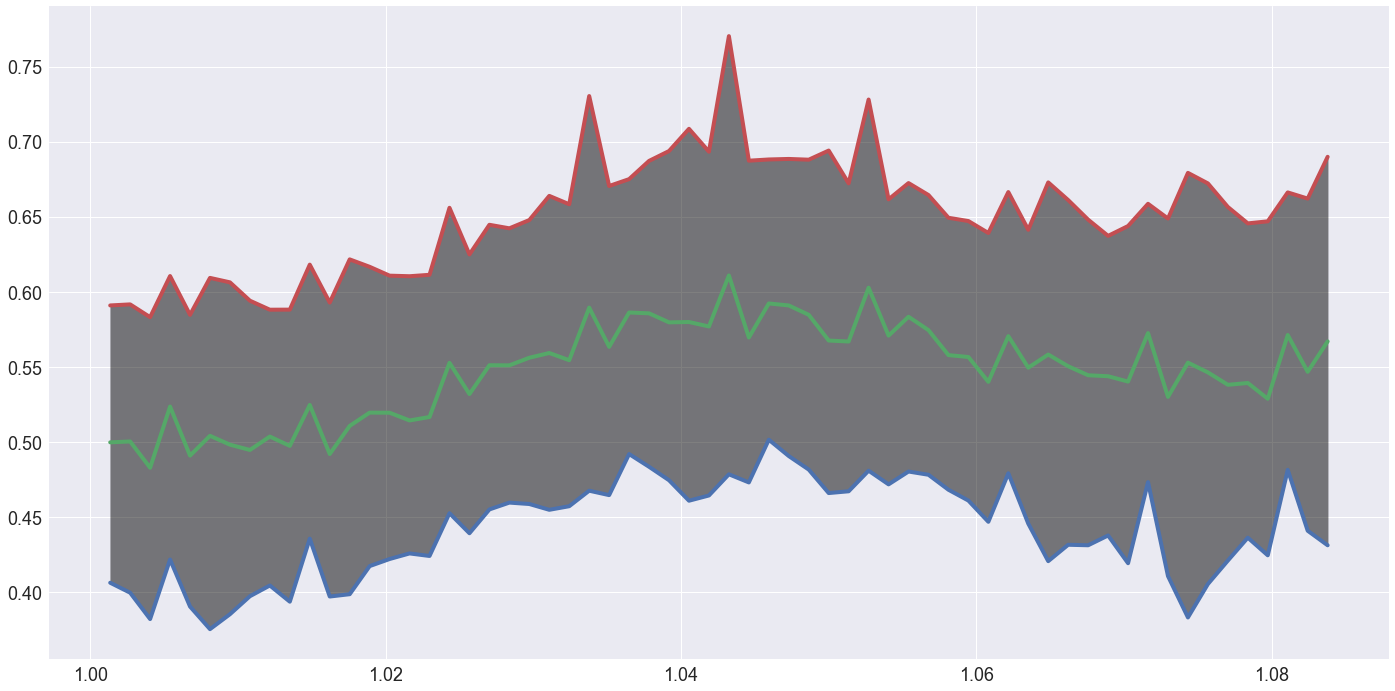

In [113]:
# for i in range(y_pred.shape[2]):
#     s = np.percentile([yi[0][i] for yi in y_pred], [5,95])
#     print(s)

y_pred = np.array([sess.run([y_post], 
                  feed_dict=test_data) for _ in range(5000)])

CI_l = 20
CI_u = 100-CI_l
ci = []
for j in range(y_pred.shape[2]):
    lower = np.percentile(y_pred,[CI_l,CI_u], axis=0)[0][0]
    upper = np.percentile(y_pred,[CI_l,CI_u], axis=0)[1][0]
    mean = np.mean(y_pred, axis=0)[0]

plt.plot(future['ds'], lower,lw=4)
plt.plot(future['ds'], mean,lw=4)
plt.plot(future['ds'], upper,lw=4)
plt.fill_between(future['ds'], lower,upper,color='k',alpha=.5)
plt.show()


    
        


MAPE = 4.323237
SMAPE = 4.401018
MSE = 0.000937


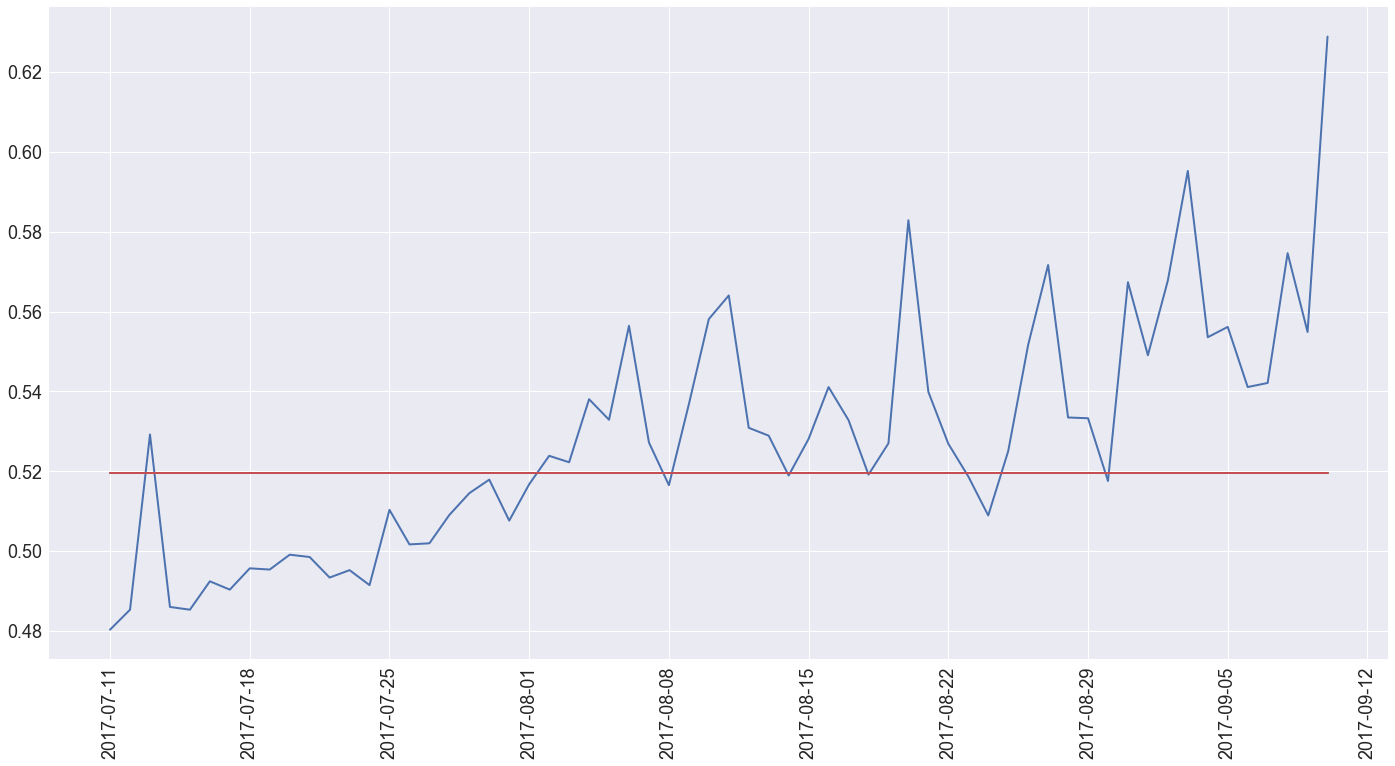

In [9]:
# Benchmark
def median_model(history, p=-50):
    visits = np.nan_to_num(np.nanmedian(history['y_scaled'].values[-p:]))
    return np.ones(future.shape[0]) * visits

y_pred_median = median_model(history)
evaluate(future['y_scaled'], y_pred_median)
plot_evaluate(future['ds'],future['y_scaled'],y_pred_median)
plt.plot(future['ds'], y_pred_median)
plt.show()

## Evaluation on train data

Evalaute train data
MAPE = 6.045712
SMAPE = 6.156764
MSE = 0.002417


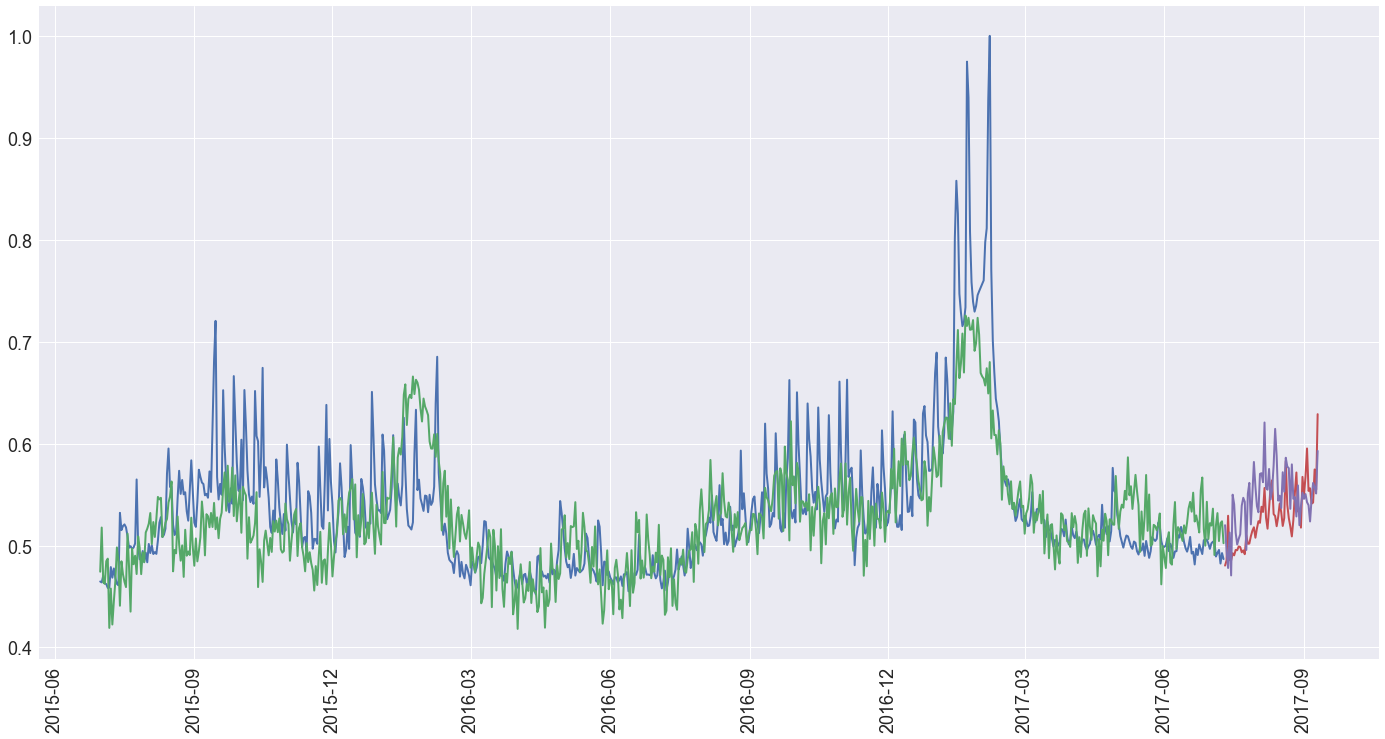

train data before log
MAPE = 40.743281
SMAPE = 39.549621
MSE = 236079289.483991


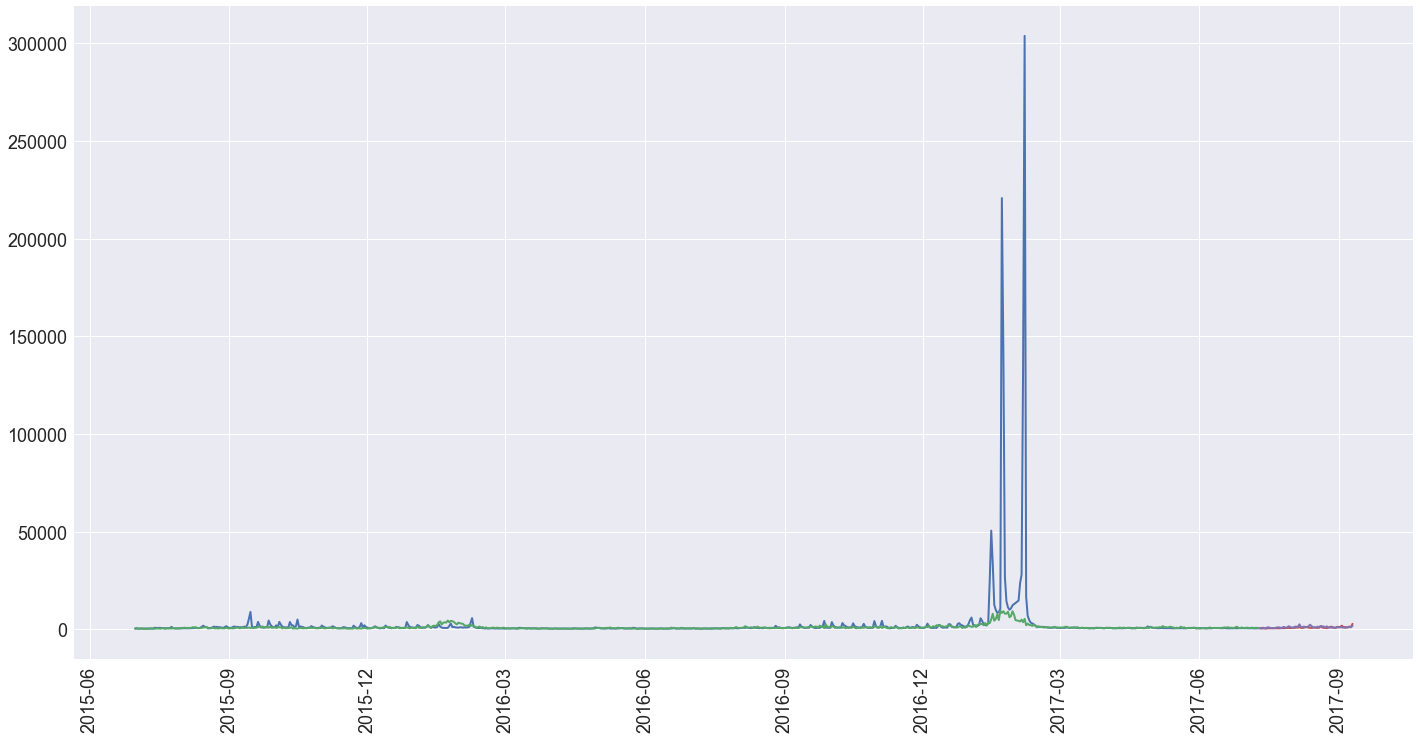

In [10]:
# Training error 
y_train_pred = np.array([sess.run([y_post], 
                                  feed_dict={t: X_train['t'],
                                             A: X_train['A'], X: X_train['X'].as_matrix(), 
                                             sigmas: X_train['sigmas'], t_change: changepoints_t}
                                                #tau: changepoint_prior_scale}))
                                 ) for _ in range(500)]).mean(axis=0)[0]


print("Evalaute train data") 
evaluate(history['y_scaled'], y_train_pred)
plot_evaluate(history['ds'], history['y_scaled'],y_train_pred)
plot_evaluate(future['ds'],future['y_scaled'],y_pred)
plt.show()

print("train data before log") 
evaluate(history['views'],np.exp(y_train_pred * y_scale))
plot_evaluate(history['ds'], history['views'],np.exp(y_train_pred * y_scale))
plot_evaluate(future['ds'],future['views'],np.exp(y_pred * y_scale))
plt.show()

# plot_APE(history['ds'], history['y_scaled'],y_train_pred, 'y_scaled')
# plt.show()

## Posterior Check & PPC

Inferred posterior k: mean = -0.022934, stddev = 0.041407
Inferred posterior m: mean = 0.516885, stddev = 0.026321
Inferred posterior tau: mean = 0.018396, stddev = 0.011341
Inferred posterior noise: mean = 0.212669, stddev = 0.302154


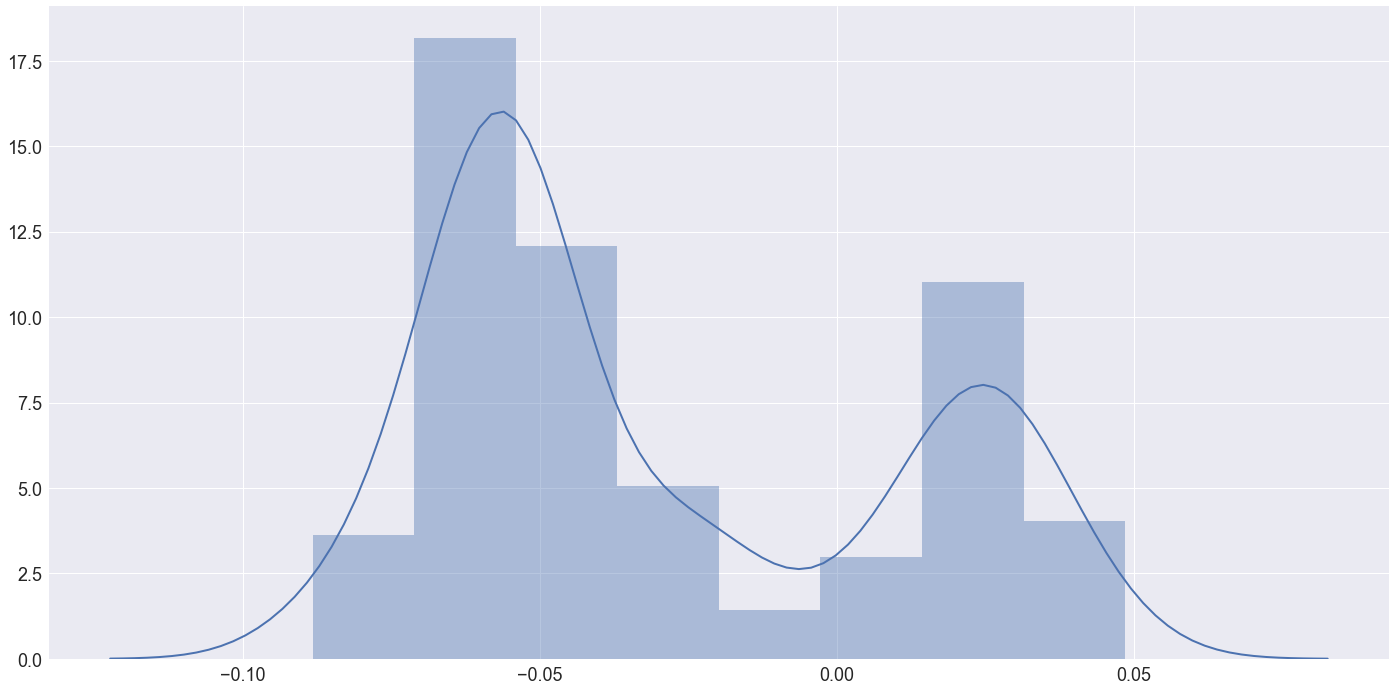

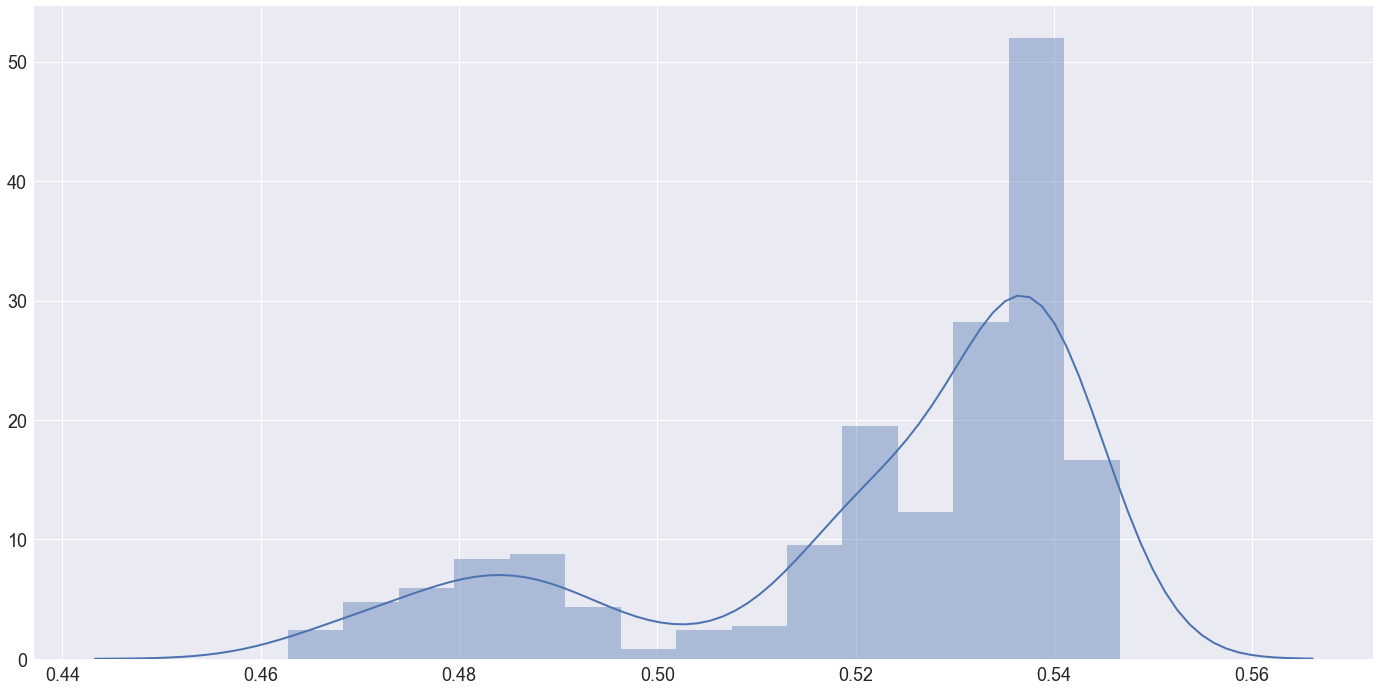

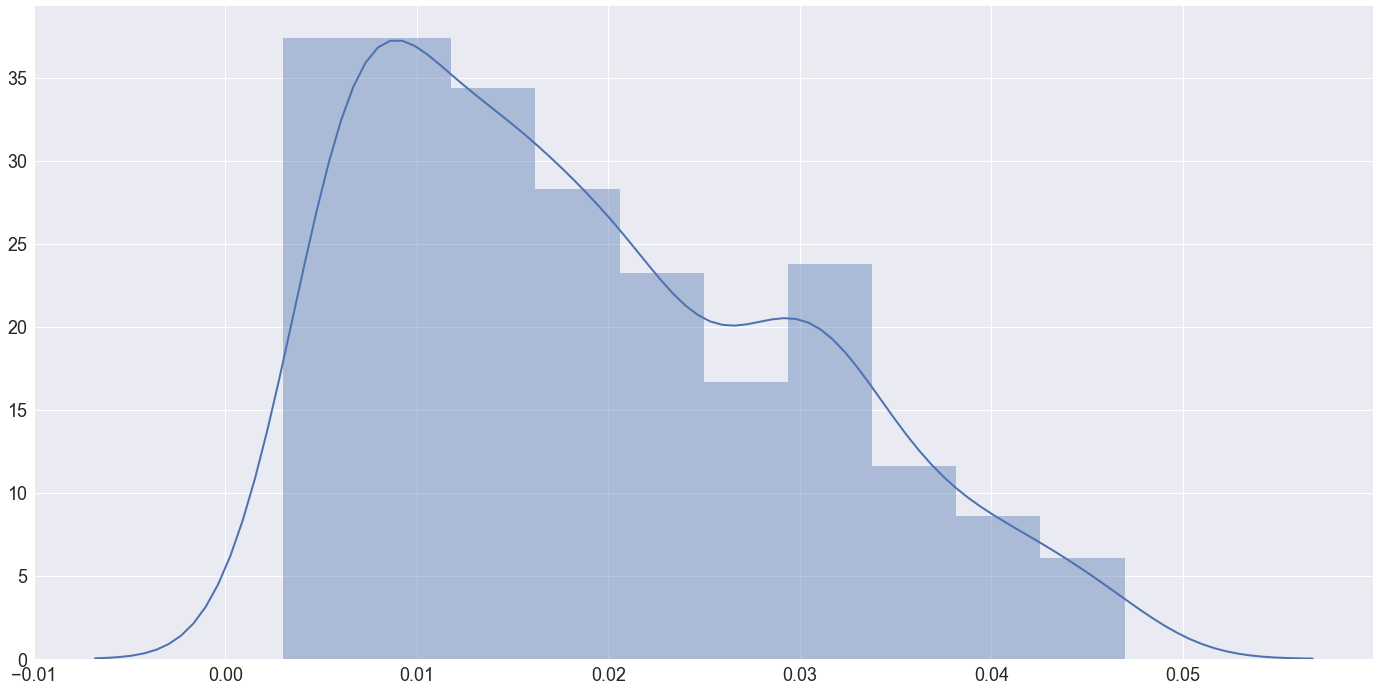

In [116]:
# Posterior check
kmean, kstddev = sess.run([qk.mean(), qk.stddev()])
print("Inferred posterior k: mean = %f, stddev = %f" % (kmean, kstddev))
mmean, mstddev = sess.run([qm.mean(), qm.stddev()])
print("Inferred posterior m: mean = %f, stddev = %f" % (mmean, mstddev))
tau_mean, tau_stddev = sess.run([qtau.mean(), qtau.stddev()])
print("Inferred posterior tau: mean = %f, stddev = %f" % (tau_mean, tau_stddev))


noise_mean, noise_stddev = sess.run([qsigma_obs.mean(), qsigma_obs.stddev()])
print("Inferred posterior noise: mean = %f, stddev = %f" % (noise_mean, noise_stddev))

nburn = 500
stride = 10
sns.distplot(qk.params.eval()[nburn:ITR:stride])
plt.show()
sns.distplot(qm.params.eval()[nburn:ITR:stride])
plt.show()

sns.distplot(qtau.params.eval()[nburn:ITR:stride])
plt.show()

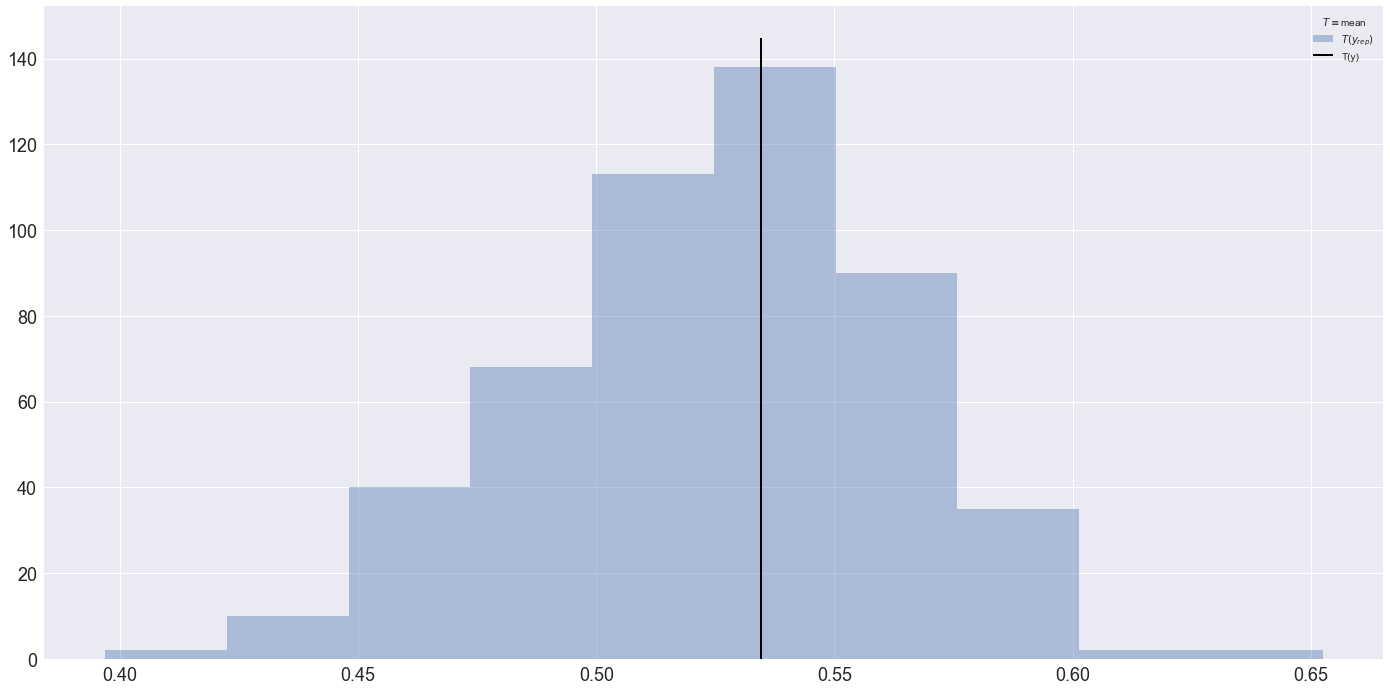

In [115]:
import seaborn as sns
sns.__version__

# test data
y_post = ed.copy(y, {k: qk, m: qm, sigma_obs: qsigma_obs, beta: qbeta, delta:qdelta, tau:qtau})
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_mean(xs[y_post]), 
       data={y_post: Y_train, 
            t: X_train['t'],
            A: X_train['A'], 
            X: X_train['X'].as_matrix(), 
            sigmas: X_train['sigmas'], 
            t_change: changepoints_t}
#             tau: changepoint_prior_scale}
                    ,n_samples=500)               
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

## Cross Validation

In [58]:
def tsCV(df, k, max_train_size = None):
    # Method: kfolds
    #     Train on fold 1, test on 2
    #     Train on fold 1+2, test on 3
    #     Train on fold 1+2+3, test on 4
    
    # df: data for time series cv
    # k: number of folds
    # max_train_size
    n = df.shape[0]
    splits = k - 1
    if k > n:
        raise ValueError(
            ("Cannot have number of folds ={0} greater"
                " than the number of samples: {1}.").format(k,n))
    print("number of total data points: ", n)
    print("number of folds: ", k) 
    
    indices = np.arange(n)
    test_size = (n // k)
    test_idx = range(test_size + n % k,
                        n, test_size)
    for test_start in test_idx:
        if max_train_size and max_train_size < test_start:
            yield (df.loc[test_start - max_train_size:test_start],
                   df.loc[test_start:test_start + test_size])
        else:
            yield (df.loc[:test_start],
                   df.loc[test_start:test_start + test_size])
            
def tsCV2(df, k=365, h=1, cut = 60):
    # Method: rolling forecasting
    #     Train on :k+i-1, test on k+h+i-1
    #     h=1: forecast on next data point
    
    # df: data for time series cv
    # k: number of min train observations required
    # h: h-step ahead forecast
    n = df.shape[0]

    for i in range(0,n-k-h):
        train_i = k+i
        test_i = k+h+i
        yield (df.loc[:(train_i)],
               df.loc[[(test_i)]])
        
def tsCV3(df, k=365, h=1):
    # Method: rolling forecasting
    #     Train on :k+i-1, test on k+h+i-1
    #     h=1: forecast on next data point
    
    # df: data for time series cv
    # k: number of min train observations required
    # h: h-step ahead forecast
    n = df.shape[0]

    for i in range(0,n-k-h):
        train_i = k+i
        test_i = k+h+i
        yield (df.loc[:(train_i)],
               df.loc[[(test_i)]])

In [73]:
print(history.shape[0])
# for train, test in tsCV(history, 3):
#     print("TRAIN:", train.shape, "TEST:", test.shape)
#     print("TRAIN:", train.head(2), "TEST:", test.head(2))

for train, test in tsCV2(history, k=365, h=1):
    print("TRAIN untill:", train.tail(1)['ds'].values, "TEST:", test['ds'].values)

741
TRAIN untill: ['2016-06-30T00:00:00.000000000'] TEST: ['2016-07-01T00:00:00.000000000']
TRAIN untill: ['2016-07-01T00:00:00.000000000'] TEST: ['2016-07-02T00:00:00.000000000']
TRAIN untill: ['2016-07-02T00:00:00.000000000'] TEST: ['2016-07-03T00:00:00.000000000']
TRAIN untill: ['2016-07-03T00:00:00.000000000'] TEST: ['2016-07-04T00:00:00.000000000']
TRAIN untill: ['2016-07-04T00:00:00.000000000'] TEST: ['2016-07-05T00:00:00.000000000']
TRAIN untill: ['2016-07-05T00:00:00.000000000'] TEST: ['2016-07-06T00:00:00.000000000']
TRAIN untill: ['2016-07-06T00:00:00.000000000'] TEST: ['2016-07-07T00:00:00.000000000']
TRAIN untill: ['2016-07-07T00:00:00.000000000'] TEST: ['2016-07-08T00:00:00.000000000']
TRAIN untill: ['2016-07-08T00:00:00.000000000'] TEST: ['2016-07-09T00:00:00.000000000']
TRAIN untill: ['2016-07-09T00:00:00.000000000'] TEST: ['2016-07-10T00:00:00.000000000']
TRAIN untill: ['2016-07-10T00:00:00.000000000'] TEST: ['2016-07-11T00:00:00.000000000']
TRAIN untill: ['2016-07-11T0

TRAIN untill: ['2016-12-14T00:00:00.000000000'] TEST: ['2016-12-15T00:00:00.000000000']
TRAIN untill: ['2016-12-15T00:00:00.000000000'] TEST: ['2016-12-16T00:00:00.000000000']
TRAIN untill: ['2016-12-16T00:00:00.000000000'] TEST: ['2016-12-17T00:00:00.000000000']
TRAIN untill: ['2016-12-17T00:00:00.000000000'] TEST: ['2016-12-18T00:00:00.000000000']
TRAIN untill: ['2016-12-18T00:00:00.000000000'] TEST: ['2016-12-19T00:00:00.000000000']
TRAIN untill: ['2016-12-19T00:00:00.000000000'] TEST: ['2016-12-20T00:00:00.000000000']
TRAIN untill: ['2016-12-20T00:00:00.000000000'] TEST: ['2016-12-21T00:00:00.000000000']
TRAIN untill: ['2016-12-21T00:00:00.000000000'] TEST: ['2016-12-22T00:00:00.000000000']
TRAIN untill: ['2016-12-22T00:00:00.000000000'] TEST: ['2016-12-23T00:00:00.000000000']
TRAIN untill: ['2016-12-23T00:00:00.000000000'] TEST: ['2016-12-24T00:00:00.000000000']
TRAIN untill: ['2016-12-24T00:00:00.000000000'] TEST: ['2016-12-25T00:00:00.000000000']
TRAIN untill: ['2016-12-25T00:00

TRAIN untill: ['2017-06-09T00:00:00.000000000'] TEST: ['2017-06-10T00:00:00.000000000']
TRAIN untill: ['2017-06-10T00:00:00.000000000'] TEST: ['2017-06-11T00:00:00.000000000']
TRAIN untill: ['2017-06-11T00:00:00.000000000'] TEST: ['2017-06-12T00:00:00.000000000']
TRAIN untill: ['2017-06-12T00:00:00.000000000'] TEST: ['2017-06-13T00:00:00.000000000']
TRAIN untill: ['2017-06-13T00:00:00.000000000'] TEST: ['2017-06-14T00:00:00.000000000']
TRAIN untill: ['2017-06-14T00:00:00.000000000'] TEST: ['2017-06-15T00:00:00.000000000']
TRAIN untill: ['2017-06-15T00:00:00.000000000'] TEST: ['2017-06-16T00:00:00.000000000']
TRAIN untill: ['2017-06-16T00:00:00.000000000'] TEST: ['2017-06-17T00:00:00.000000000']
TRAIN untill: ['2017-06-17T00:00:00.000000000'] TEST: ['2017-06-18T00:00:00.000000000']
TRAIN untill: ['2017-06-18T00:00:00.000000000'] TEST: ['2017-06-19T00:00:00.000000000']
TRAIN untill: ['2017-06-19T00:00:00.000000000'] TEST: ['2017-06-20T00:00:00.000000000']
TRAIN untill: ['2017-06-20T00:00

## Visualize

In [ ]:
# def visualise(X_data, y_data, k, m, sigma_obs, beta, delta, n_samples=10):
#     k = k.sample(n_samples).eval()
#     m = m.sample(n_samples).eval()
#     sigma_obs = sigma_obs.sample(n_samples).eval()
# #     beta = beta.sample(n_samples).eval()
# #     delta = delta.sample(n_samples).eval()
#     plt.scatter(X_data.iloc[:, 0], y_data)
#     inputs = np.linspace(-1, 1, num=400)
#     for ns in range(n_samples):
#         output = ???
#     plt.plot(inputs, output)
# visualise(data['X'], data['y'],k, m, sigma_obs, beta, delta)
# visualise(data['X'], data['y'],qk, qm, qsigma_obs, qbeta, qdelta)

# Facebook Prophet


In [ ]:
# from fbprophet import Prophet

# # Facebook Prophet
# df = pd.read_csv("./data/Selena_en.wikipedia.org_all-access_spider.csv")
# df["y"] = np.log(df["y"])
# df.head()
# m_pp = Prophet()
# m_pp.fit(history)

In [ ]:
# future = m_pp.make_future_dataframe(periods=60)
# future.tail()
# forecast = m_pp.predict(future)
# forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# m_pp.plot(forecast);

In [ ]:
# m_pp.plot_components(forecast);

In [ ]:
# evalute(forecast['yhat_'], y_pred)